# Purpose

2021-12-23: v0.4.1 Use this notebook run hydra-based clustering script. Use this as a way to document different options for running the script with hydra.

Focus:
- clustering algos at **subreddit-level.**


# Imports & Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [20]:
from datetime import datetime
import logging
import os
from pathlib import Path

import numpy as np
import pandas as pd
import plotly
import seaborn as sns

import mlflow
import hydra

import subclu
from subclu.eda.aggregates import compare_raw_v_weighted_language
from subclu.utils import set_working_directory, get_project_subfolder
from subclu.utils.eda import (
    setup_logging, counts_describe, value_counts_and_pcts,
    notebook_display_config, print_lib_versions,
    style_df_numeric, reorder_array,
)
from subclu.utils.mlflow_logger import MlflowLogger
from subclu.utils.hydra_config_loader import LoadHydraConfig
from subclu.utils.data_irl_style import (
    get_colormap, theme_dirl, 
    get_color_dict, base_colors_for_manual_labels,
    check_colors_used,
)
from subclu.data.data_loaders import LoadPosts, LoadSubreddits, create_sub_level_aggregates


# ===
# imports specific to this notebook
from collections import Counter
# import umap
# import openTSNE
# from openTSNE import TSNE

# import hdbscan

import sklearn
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize  # if we normalize the data, euclidean distance is approx of cosine

from sklearn.cluster import KMeans, DBSCAN, OPTICS, AgglomerativeClustering

from subclu.models.clustering import ClusterEmbeddings
from subclu.models.clustering_utils import plot_elbow_and_get_k


print_lib_versions([hydra, np, pd, plotly, sklearn, sns, subclu])

python		v 3.7.10
===
hydra		v: 1.1.0
numpy		v: 1.19.5
pandas		v: 1.2.4
plotly		v: 4.14.3
sklearn		v: 0.24.1
seaborn		v: 0.11.1
subclu		v: 0.4.1


In [3]:
# plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
plt.style.use('default')

setup_logging()
notebook_display_config()

# Set sqlite database as MLflow URI

In [4]:
# use new class to initialize mlflow
mlf = MlflowLogger(tracking_uri='sqlite')
mlflow.get_tracking_uri()

'sqlite:////home/jupyter/subreddit_clustering_i18n/mlflow_sync/djb-100-2021-04-28-djb-eda-german-subs/mlruns.db'

## Get list of experiments with new function

In [5]:
mlf.list_experiment_meta(output_format='pandas').tail(9)

,experiment_id,name,artifact_location,lifecycle_stage
16,16,v0.4.0_use_multi_aggregates,gs://i18n-subreddit-clustering/mlflow/mlruns/16,active
17,17,v0.4.0_use_multi_clustering_test,gs://i18n-subreddit-clustering/mlflow/mlruns/17,active
18,18,v0.4.0_use_multi_clustering,gs://i18n-subreddit-clustering/mlflow/mlruns/18,active
19,19,v0.4.1_mUSE_inference_test,gs://i18n-subreddit-clustering/mlflow/mlruns/19,active
20,20,v0.4.1_mUSE_inference,gs://i18n-subreddit-clustering/mlflow/mlruns/20,active
21,21,v0.4.1_mUSE_aggregates_test,gs://i18n-subreddit-clustering/mlflow/mlruns/21,active
22,22,v0.4.1_mUSE_aggregates,gs://i18n-subreddit-clustering/mlflow/mlruns/22,active
23,23,v0.4.1_mUSE_clustering_test,gs://i18n-subreddit-clustering/mlflow/mlruns/23,active
24,24,v0.4.1_mUSE_clustering,gs://i18n-subreddit-clustering/mlflow/mlruns/24,active


## Get experiment IDs to use for clustering

There are two runs that completed and they both have the same parameters, so we should be able to use either one. For now, let's select:<br>
`0591fdae9b7d4da7ae3839767b8aab66`

In [6]:
%%time

df_mlf = mlf.search_all_runs(experiment_ids=[22])
df_mlf.shape

CPU times: user 56.8 ms, sys: 390 µs, total: 57.2 ms
Wall time: 56.4 ms


(1, 64)

In [7]:
df_mlf.head()

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.df_post_level_agg_c_post_comments_sub_desc-cols,metrics.memory_total,metrics.comments_raw_rows,metrics.memory_used,metrics.comments_raw_cols,metrics.sub_description_raw_rows,metrics.cpu_count,metrics.posts_raw_rows,metrics.posts_raw_cols,metrics.df_sub_level_agg_c_post_comments_and_sub_desc-cols,metrics.df_post_level_agg_c_post_comments_sub_desc-rows,metrics.df_sub_level_agg_a_post_only-rows,metrics.memory_free,metrics.sub_description_raw_cols,metrics.memory_used_percent,metrics.df_sub_level_agg_a_post_only-cols,metrics.df_sub_level_agg_c_post_comments_and_sub_desc-rows,params.unique_checks,params.bucket_name,params.run_name,params.agg_post_to_subreddit_weight_col,params.folder_posts_text_and_meta,params.col_subreddit_id,params.folder_subreddits_text_and_meta,...,params.f_log_file,params.agg_post_post_weight,params.comments_folder,params.col_post_id,params.col_comment_id,params.subreddit_desc_folder,params.host_name,params.memory_total,params.n_sample_comments_files,params.agg_comments_to_post_weight_col,params.mlflow_experiment,params.comments_uuid,params.agg_post_comment_weight,params.n_sample_posts_files,params.folder_comments_text_and_meta,params.agg_post_subreddit_desc_weight,params.cpu_count,params.col_text_post_word_count,params.posts_folder,params.logs_path,params.mlflow_tracking_uri,params.posts_uuid,params.col_comment_text_len,params.min_comment_text_len,tags.host_name,tags.mlflow.source.git.commit,tags.mlflow.runName,tags.mlflow.user,tags.mlflow.source.type,tags.mlflow.source.name
0,4144c443722e47ef9cd2f42a5e813f3b,22,RUNNING,gs://i18n-subreddit-clustering/mlflow/mlruns/22/4144c443722e47ef9cd2f42a5e813f3b/artifacts,2021-12-23 11:20:55.413000+00:00,None,515.0,1937274.0,54407324.0,419733.0,516.0,49705.0,80.0,15629958.0,515.0,514.0,15629958.0,49625.0,1690826.0,514.0,0.216662,514.0,49625.0,False,i18n-subreddit-clustering,agg_full_lc_false_pd-2021-12-23_112054,None,posts/top/2021-12-14_fix,subreddit_id,subreddits/top/2021-12-14,...,logs/AggregateEmbeddings/2021-12-23_11-20-55_agg_full_lc_false_pd-2021-12-23_112054.log,70,df_vect_comments,post_id,comment_id,df_vect_subreddits_description,djb-100-2021-04-28-djb-eda-german-subs,1937274,None,None,v0.4.1_mUSE_aggregates,"['26c8fcf422a9403ba4a844c8e380bf7f', '54ba724869bf4ec9a2cad2a4f7eca048', 'e7ed11ccdc0b45abbdf3bf19605d4498', 'a69d1b259875458283124ffdaa6efbb6']",20,None,comments/top/2021-12-14,10,80,text_word_count,df_vect_posts,logs/AggregateEmbeddings,sqlite,559a8f13264245b3923ab5699ef55bfe,comment_text_len,4,djb-100-2021-04-28-djb-eda-german-subs,2e3ffe692433be950ce3fdfc0f164a9e3df6b0e4,agg_full_lc_false_pd-2021-12-23_112054,jupyter,LOCAL,/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py


In [8]:
# mask_finished = df_mlf['status'] == 'FINISHED'
# mask_df_similarity_complete = ~df_mlf['metrics.df_sub_level_agg_a_post_only_similarity-rows'].isnull()

# df_mlf_clustering_candidates = df_mlf[mask_finished & mask_df_similarity_complete]
# df_mlf_clustering_candidates.shape

In [9]:
# cols_with_multiple_vals = df_mlf_clustering_candidates.columns[df_mlf_clustering_candidates.nunique(dropna=False) > 1]

# df_mlf_clustering_candidates[cols_with_multiple_vals]

# Inspect config for clustering job

This config should include:
- data to load for clustering
- parameters for clustering algo
- hydra overrides to run jobs in parallel

In [10]:
test_experiment = 'v0.4.1_mUSE_clustering_test'

cfg_cluster_test = LoadHydraConfig(
    config_name='clustering_v0.4.1_subreddit_base.yaml',
    config_path="../config",
    overrides=[
        f"mlflow_experiment_name={test_experiment}"
#         f"data_text_and_metadata=top_subreddits_2021_07_16",
#         f"data_embeddings_to_cluster=top_subs-2021_07_16-use_multi_lower_case_false_00",
    ],
)

print([k for k in cfg_cluster_test.config_dict.keys()])

['data_text_and_metadata', 'data_embeddings_to_cluster', 'clustering_algo', 'embeddings_to_cluster', 'n_sample_embedding_rows', 'n_max_clusters_to_check_for_optimal_k', 'filter_embeddings', 'mlflow_tracking_uri', 'mlflow_experiment_name', 'pipeline_config']


In [11]:
# data with embeddings
cfg_cluster_test.config_dict['data_embeddings_to_cluster']

{'config_description': 'Config for embeddings that at post level included OCR text + URL stems',
 'run_uuid': '4144c443722e47ef9cd2f42a5e813f3b',
 'l_ix_sub': ['subreddit_name', 'subreddit_id'],
 'l_ix_post': ['subreddit_name', 'post_id'],
 'df_post_level_agg_b_post_and_comments': None,
 'df_post_level_agg_c_post_comments_sub_desc': 'df_post_level_agg_c_post_comments_sub_desc',
 'df_sub_level_agg_a_post_only': 'df_sub_level_agg_a_post_only',
 'df_sub_level_agg_a_post_only_similarity': None,
 'df_sub_level_agg_a_post_only_similarity_pair': None,
 'df_sub_level_agg_a_post_only_similarity_top_pair': None,
 'df_sub_level_agg_b_post_and_comments': None,
 'df_sub_level_agg_b_post_and_comments_similarity': None,
 'df_sub_level_agg_b_post_and_comments_similarity_pair': None,
 'df_sub_level_agg_c_post_comments_and_sub_desc': 'df_sub_level_agg_c_post_comments_and_sub_desc',
 'df_sub_level_agg_c_post_comments_and_sub_desc_similarity': None,
 'df_sub_level_agg_c_post_comments_and_sub_desc_similari

In [21]:
# clustering algo
# cfg_cluster_test.config_dict['clustering_algo']

# Run as python fnx

In [13]:
# cfg_cluster_test.config_dict

07:22:54 | INFO | "host_name: djb-100-2021-04-28-djb-eda-german-subs"
07:22:54 | INFO | "cpu_count: 80"
07:22:54 | INFO | "RAM stats:
{'memory_used_percent': '31.14%', 'memory_total': '1,937,274', 'memory_used': '603,248', 'memory_free': '929,536'}"
07:22:55 | INFO | "  Saving config to local path..."
07:22:55 | INFO | "  Logging config to mlflow with joblib..."
07:22:55 | INFO | "  Logging config to mlflow with YAML..."
07:22:57 | INFO | "Local folder to download artifact(s):
  /home/jupyter/subreddit_clustering_i18n/data/local_cache/mlflow/mlruns/22/4144c443722e47ef9cd2f42a5e813f3b/artifacts/df_sub_level_agg_c_post_comments_and_sub_desc"
100%|###########################################| 5/5 [00:00<00:00, 8100.24it/s]
07:22:57 | INFO | "  Parquet files found:     3"
07:22:57 | INFO | "  Parquet files to use:     3"
07:22:58 | INFO | "RAM stats:
{'memory_used_percent': '31.20%', 'memory_used': '604,355'}"
** Loading metadata **
07:22:58 | INFO | "Loading df_posts from: posts/top/2021-1

<Figure size 1400x800 with 0 Axes>

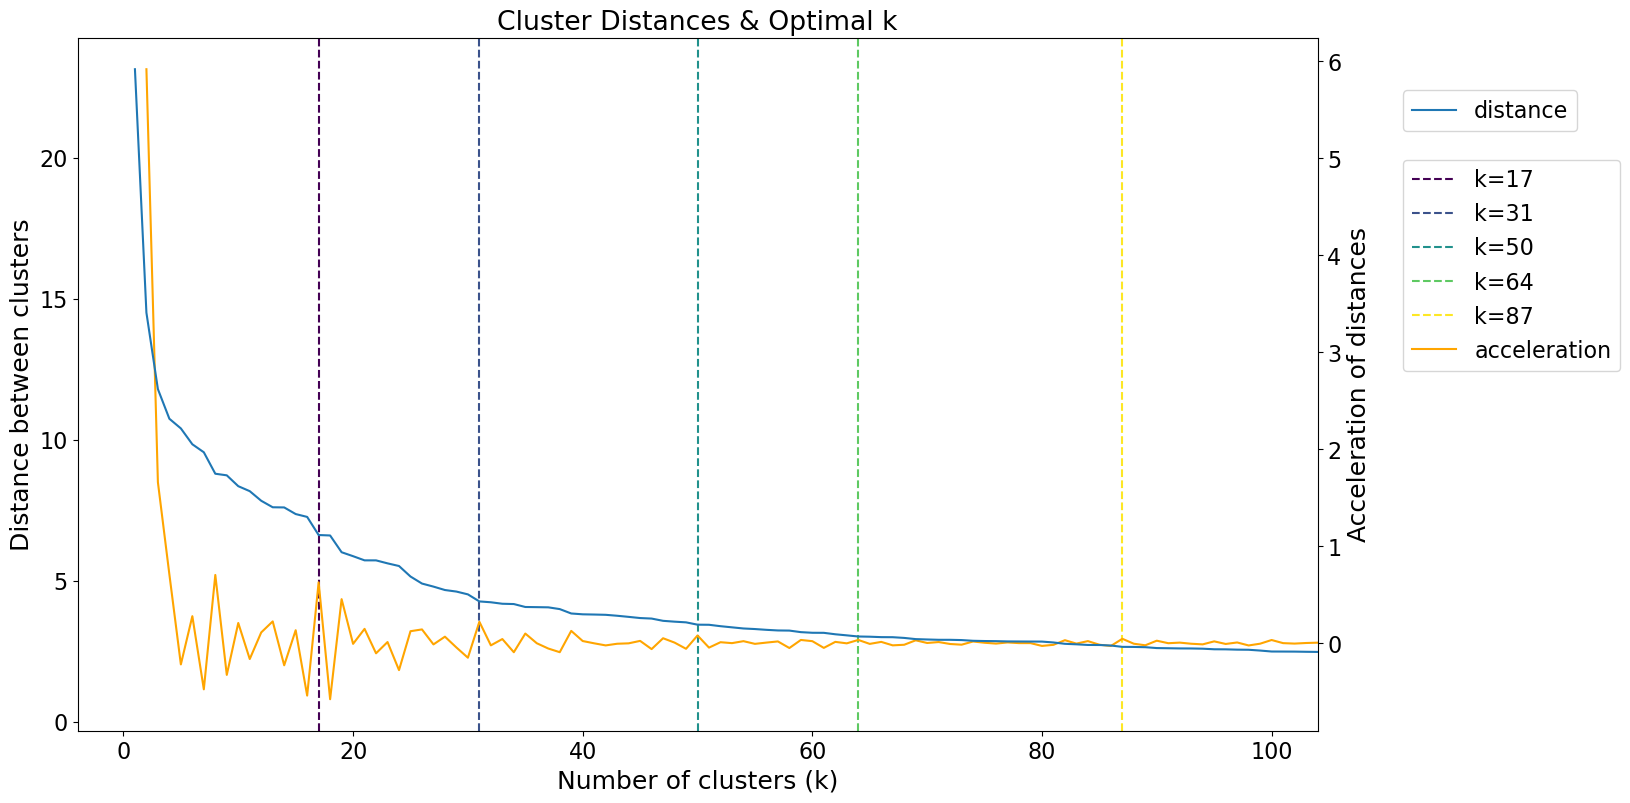

  '050_to_100'


<Figure size 1400x800 with 0 Axes>

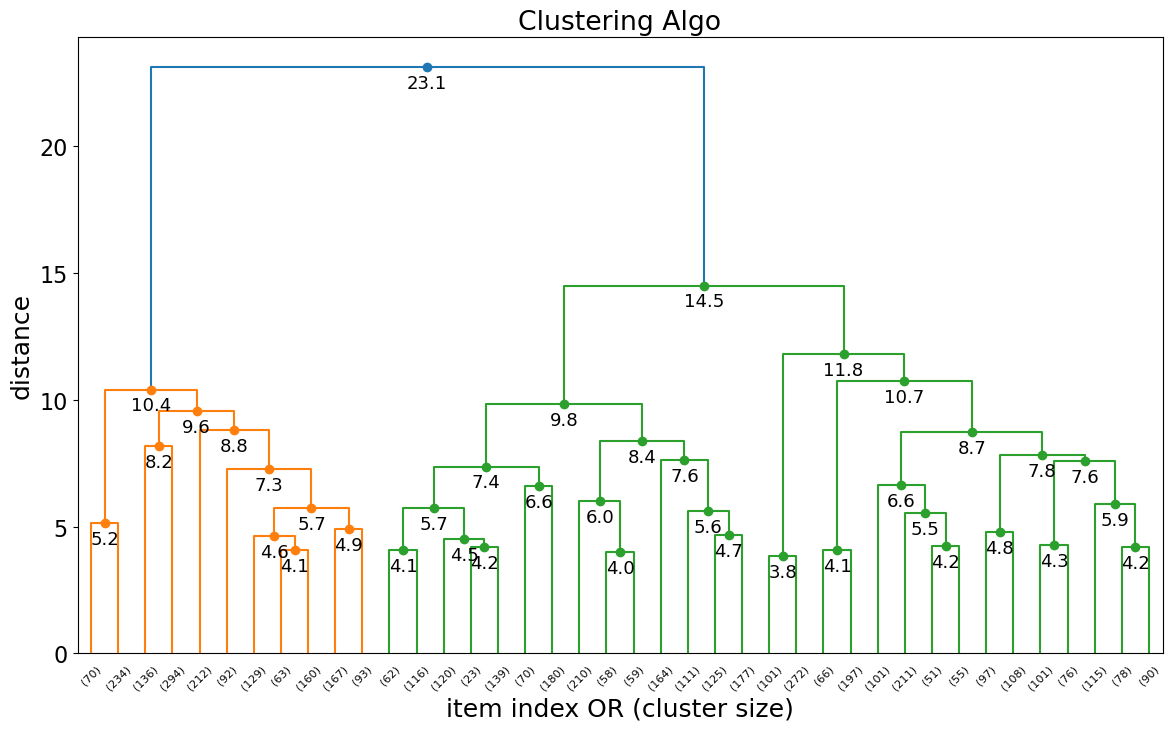


07:23:39 | INFO | "RAM stats:
{'memory_used_percent': '31.19%', 'memory_used': '604,154'}"


07:23:49 | INFO | "  0:00:55.127265 <- Total Clustering fxn time time elapsed"
07:23:49 | INFO | "RAM stats:
{'memory_used_percent': '31.19%', 'memory_used': '604,204'}"


CPU times: user 49.5 s, sys: 11 s, total: 1min
Wall time: 55.9 s


In [51]:
%%time

# use ** to over-ride config defaults
cls_test = ClusterEmbeddings(
    **{
        **cfg_cluster_test.config_dict,
        **{
            'n_sample_embedding_rows': 5000,
            'mlflow_experiment_name': test_experiment,
        }
    }
)

cls_test.run_clustering()

# Run commmand line fxn

The clustering fxn is in `subclu.models.conlustering.py`

Notes:
- We need to use the `-m` flag to run as a submodule (and allow relative imports)
- When using the `-m` flag, REMOVE the `.py` ending of the file!
- In the command line for hydra we can override w/o having to use the `+` sign.
    - https://hydra.cc/docs/tutorials/basic/your_first_app/config_file

## Check & set paths

In [36]:
test_experiment

'v0.4.1_mUSE_clustering_test'

In [37]:
os.getcwd()

'/home/jupyter/subreddit_clustering_i18n/notebooks/v0.4.1'

In [38]:
path_djb_repo = '/home/david.bermejo/repos/subreddit_clustering_i18n/' 
path_djb_models = '/home/david.bermejo/repos/subreddit_clustering_i18n/subclu/models' 
file_clustering_py = 'subclu.models.clustering'

## Run clustering from CLI

```bash
!cd $path_djb_repo && python -m $file_clustering_py \
    mlflow_experiment_name=$test_experiment \
    n_sample_embedding_rows=4000 \
    filter_embeddings.filter_subreddits.minimum_column_value=9
```

In [28]:
file_clustering_py

'subclu.models.clustering'

In [40]:
# run on sample data, test experiment

!cd $path_djb_repo && python -m $file_clustering_py \
    mlflow_experiment_name=$test_experiment \
    n_sample_embedding_rows=4000 \
    filter_embeddings.filter_subreddits.minimum_column_value=9

CFG keys: dict_keys(['data_text_and_metadata', 'data_embeddings_to_cluster', 'clustering_algo', 'embeddings_to_cluster', 'n_sample_embedding_rows', 'filter_embeddings', 'mlflow_tracking_uri', 'mlflow_experiment_name', 'pipeline'])
`2021-12-24 02:36:36,483` | `INFO` | `Define cluster class...`
`2021-12-24 02:36:37,390` | `INFO` | `== Start run_aggregation() method ==`
`2021-12-24 02:36:37,390` | `INFO` | `MLflow tracking URI: sqlite:////home/jupyter/subreddit_clustering_i18n/mlflow_sync/djb-100-2021-04-28-djb-eda-german-subs/mlruns.db`
`2021-12-24 02:36:37,570` | `INFO` | `=== START CLUSTERING - Process ID 20369`
`2021-12-24 02:36:37,679` | `INFO` | `host_name: djb-100-2021-04-28-djb-eda-german-subs`
`2021-12-24 02:36:37,679` | `INFO` | `cpu_count: 80`
`2021-12-24 02:36:37,761` | `INFO` | `RAM stats:
{'memory_used_percent': '31.08%', 'memory_total': '1,937,274', 'memory_used': '602,066', 'memory_free': '930,727'}`
`2021-12-24 02:36:37,884` | `INFO` | `Using hydra's path`
  Current worki

In [30]:
# Since we're including 50k subreddits for modeling
# if clusters were even, at k=1000, we'd expect an average of 50 subreddits per cluster
50000 / 1000

50.0

In [32]:
# We might need to go down to 2,000 clusters to get more fine-grained sub-clusters
50000 / 2000

25.0

## Test multirun

Jobs can run in parallel with `--multirun` flag!

In [ ]:
# run on sample data, multi-run

!cd $path_djb_repo && python -m $file_clustering_py --multirun \
    "filter_embeddings.filter_subreddits.minimum_column_value=range(2, 10, 1)" \
    mlflow_experiment_name=$test_experiment \
    n_sample_embedding_rows=4000

## Run on full data (one job)

In [40]:
# # run on full data, still a test

# !cd $path_djb_repo && python -m $file_clustering_py mlflow_experiment_name=$test_experiment

In [56]:
# # # run on full data, no longer a test

# !cd $path_djb_repo && python -m $file_clustering_py

## Run on full data (multijob)

In [76]:
# ward-related jobs
!cd $path_djb_repo && python -m $file_clustering_py --multirun \
    "filter_embeddings.filter_subreddits.minimum_column_value=range(2, 10, 1)" \
    "pipeline.normalize.add_step=choice(false, true)" \
    "pipeline.reduce.add_step=choice(false, true)"

In [75]:
# non-ward linkages

!cd $path_djb_repo && python -m $file_clustering_py --multirun \
    "clustering_algo.model_kwargs.linkage=choice('complete', 'average')" \
    "clustering_algo.model_kwargs.affinity=choice('cosine', 'euclidean')" \
    "filter_embeddings.filter_subreddits.minimum_column_value=range(2, 10, 1)" \
    "pipeline.reduce.add_step=choice(false, true)" \
    "pipeline.normalize.add_step=false"